## Imports

In [146]:
import os
import sys
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import xarray as xr
from datetime import date, timedelta
import cartopy.crs as ccrs
from scipy.ndimage import gaussian_filter
import cartopy.feature as cfeature
from scipy.fft import fft2, fftshift


In [147]:
# Path to the config file (relative or absolute)
CONFIG_FILE = Path("config.json")

# Load config
with open(CONFIG_FILE, "r") as f:
    config = json.load(f)
    
PAR_DIR = config["PAR_DIR"]
if PAR_DIR not in sys.path:
    sys.path.append(PAR_DIR)

DATA_PATH = Path(config["DATA_PATH"])

## Load data

In [148]:
safran_1958_1988 = xr.open_dataset(DATA_PATH / "safran_1958_1988.nc")
safran_1989_2025 = xr.open_dataset(DATA_PATH / "safran_1989_2025.nc")

In [210]:
safran_1958_1988

<xarray.Dataset> Size: 3GB
Dimensions:      (time: 11111, y: 109, x: 180)
Coordinates:
  * time         (time) datetime64[ns] 89kB 1958-08-01 1958-08-02 ... 1988-12-31
  * x            (x) float64 1kB -5.347 -5.257 -5.166 ... 10.66 10.75 10.84
  * y            (y) float64 872B 51.11 51.02 50.93 50.84 ... 41.53 41.44 41.35
Data variables:
    PRELIQ_Q     (time, y, x) float32 872MB ...
    T_Q          (time, y, x) float32 872MB ...
    FF_Q         (time, y, x) float32 872MB ...
    spatial_ref  int32 4B ...
Attributes:
    description:  Données quotidiennes du modèle de simulation des schémas de...
    id:           safran-isba
    title:        Safran-Isba, Données changement climatique - SIM quotidienne
    crs:          EPSG:4326
    rel:          https://www.etalab.gouv.fr/licence-ouverte-open-licence/

In [149]:
day_test = safran_1989_2025.sel(time="2010-01-01")
precip_data = day_test.PRELIQ_Q.data
# precip_data = gaussian_filter(precip_data, sigma=0.5)
wind_data = day_test.FF_Q.data
# wind_data = gaussian_filter(wind_data, sigma=0.5)

In [150]:
min_lat = (float(day_test.y.min()))
max_lat = (float(day_test.y.max()))
min_lon = (float(day_test.x.min()))
max_lon = (float(day_test.x.max()))
extent_safran = [min_lon, max_lon, min_lat, max_lat]

In [151]:
precip_data[40:50, 40:50]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [152]:
def compute_1d_power_spectrum(image):    
    # Compute 2D FFT and shift zero frequency to center
    f_transform = fftshift(fft2(image))
    
    # Compute power spectrum (magnitude squared)
    power_spectrum = np.abs(f_transform)**2

    # Create a radial distance map
    y, x = np.indices(image.shape)
    center = np.array(image.shape) // 2
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    r = r.astype(np.int32)

    # Compute 1D power spectrum by averaging over rings
    tbin = np.bincount(r.ravel(), power_spectrum.ravel())
    nr = np.bincount(r.ravel())
    radial_profile = tbin / (nr + 1e-8)  # Avoid division by zero

    return radial_profile

In [153]:
def plot_maps(data1, data2, 
              cmap1, cmap2, 
              label1, label2,
              title1, title2, 
              extent1, extent2):
    fig = plt.figure(figsize=(15, 7))
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.15)

    ax1 = fig.add_subplot(gs[0], projection=ccrs.EuroPP())
    ax2 = fig.add_subplot(gs[1], projection=ccrs.EuroPP())

    for ax in [ax1, ax2]:
        ax.set_extent(extent1 if ax == ax1 else extent2, crs=ccrs.PlateCarree())
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.7)
        gl.right_labels = False
        ax.set_aspect('equal')

    # Plot precipitation
    precip = ax1.imshow(data1,
                        extent=extent1,
                        origin='upper',
                        cmap=cmap1,
                        alpha=1,
                        transform=ccrs.PlateCarree())
    # reduce size of colorbar
    fig.colorbar(precip, ax=ax1, orientation='vertical', label=label1, shrink=0.75)

    # Plot wind speed
    winds = ax2.imshow(data2,
                    extent=extent2,
                    origin='upper',
                    cmap=cmap2,
                    alpha=1,
                    transform=ccrs.PlateCarree())
    fig.colorbar(winds, ax=ax2, orientation='vertical', label=label2, shrink=0.75)

    # Set titles
    ax1.set_title(title1)
    ax2.set_title(title2)

    plt.show()

In [154]:
# define a function to plot the 1D power spectrum of a 2D array
def plot_power_spectrum(data1, data2, label1, label2, title):
    p1 = compute_1d_power_spectrum(data1)
    p2 = compute_1d_power_spectrum(data2)
    # plot the 1D power spectrum
    plt.figure(figsize=(10, 5))
    plt.plot(p1, label=label1)
    plt.plot(p2, label=label2)
    plt.title(title)
    plt.legend()
    plt.xlabel('Spatial Frequency')
    plt.ylabel('Power')
    plt.yscale('log')
    plt.grid()
    plt.show()

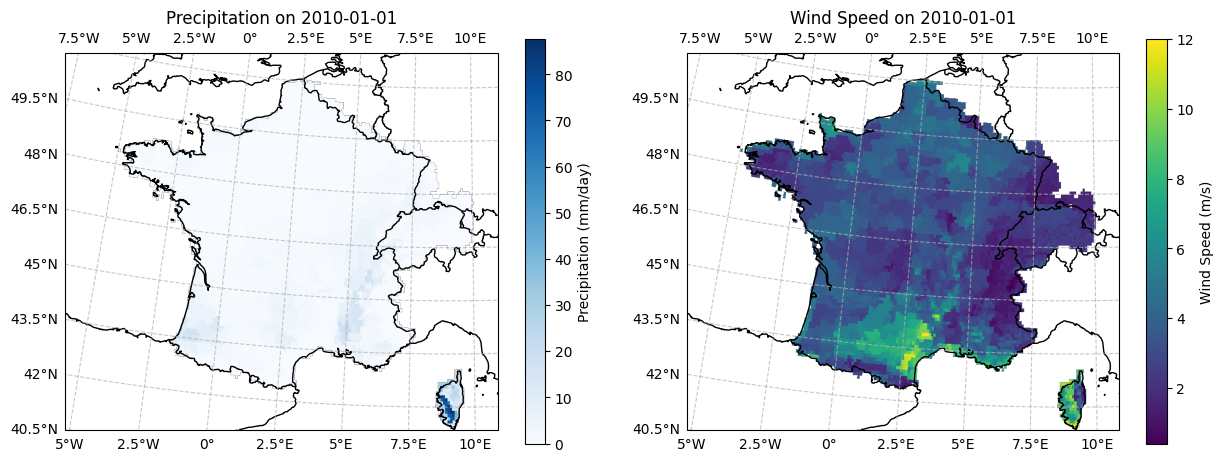

In [155]:
plot_maps(precip_data, wind_data, 
          'Blues', 'viridis', 
          'Precipitation (mm/day)', 'Wind Speed (m/s)',
          'Precipitation on 2010-01-01', 'Wind Speed on 2010-01-01', 
          extent_safran, extent_safran)

In [156]:
box = precip_data[30:50, 40:60]
# count nans in box
np.isnan(box).sum()

np.int64(0)

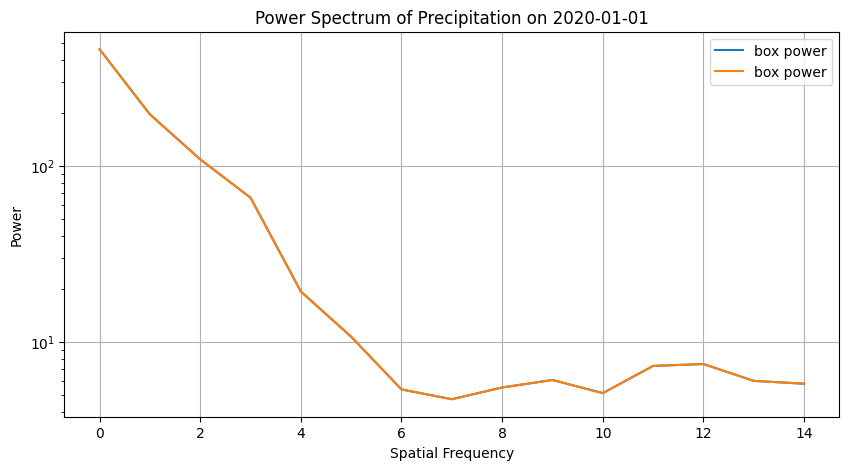

In [157]:
plot_power_spectrum(box, box, 'box power', 'box power', 'Power Spectrum of Precipitation on 2020-01-01')

## GCM data

In [158]:
cnrm = xr.open_dataset(DATA_PATH / "sfcWind_FR_CNRM-ESM2-1_370.nc")
mpi = xr.open_dataset(DATA_PATH / "sfcWind_FR_MPI-ESM1-2-LR_r1i1p1f1_gn_370.nc")

In [159]:
cnrm_day_test = cnrm.sel(time="2020-01-01")
mpi_day_test = mpi.sel(time="2020-01-01")

In [160]:
min_lat_cnrm = (float(cnrm_day_test.lat.min()))
max_lat_cnrm = (float(cnrm_day_test.lat.max()))
min_lon_cnrm = (float(cnrm_day_test.lon.min()))
max_lon_cnrm = (float(cnrm_day_test.lon.max()))
extent_cnrm = [min_lon_cnrm, max_lon_cnrm, min_lat_cnrm, max_lat_cnrm]

min_lat_mpi = (float(mpi_day_test.lat.min()))
max_lat_mpi = (float(mpi_day_test.lat.max()))
min_lon_mpi = (float(mpi_day_test.lon.min()))
max_lon_mpi = (float(mpi_day_test.lon.max()))
extent_mpi = [min_lon_mpi, max_lon_mpi, min_lat_mpi, max_lat_mpi]

In [ ]:
extent_cnrm


[-5.625, 9.84375, 41.32257587058181, 51.127866642302166]

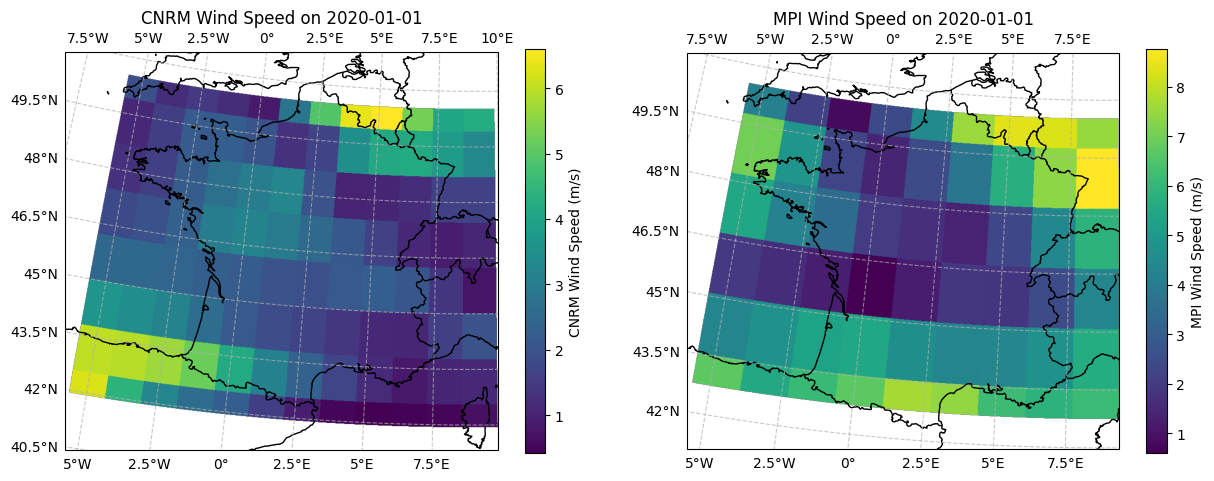

In [161]:
plot_maps(cnrm_day_test.sfcWind.data, mpi_day_test.sfcWind.data, 
          'viridis', 'viridis', 
          'CNRM Wind Speed (m/s)', 'MPI Wind Speed (m/s)',
          'CNRM Wind Speed on 2020-01-01', 'MPI Wind Speed on 2020-01-01', 
          extent_cnrm, extent_mpi)

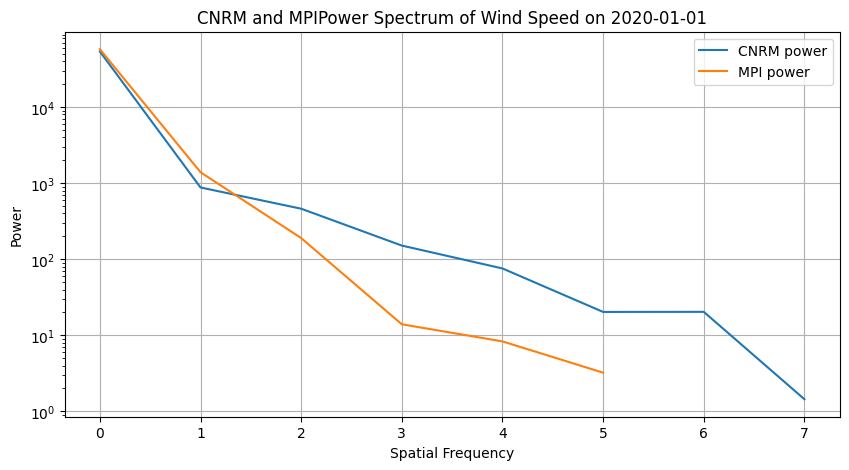

In [162]:
plot_power_spectrum(cnrm_day_test.sfcWind.data, mpi_day_test.sfcWind.data, 
                    'CNRM power', 'MPI power',
                    'CNRM and MPIPower Spectrum of Wind Speed on 2020-01-01')

## Deltas wind GCM

In [163]:
cnrm_2000_2020 = cnrm.sel(time=slice("2000-01-01", "2020-12-31"))
cnrm_2040_2060 = cnrm.sel(time=slice("2040-01-01", "2060-12-31"))
mpi_2000_2020 = mpi.sel(time=slice("2000-01-01", "2020-12-31"))
mpi_2040_2060 = mpi.sel(time=slice("2040-01-01", "2060-12-31"))

In [164]:
cnrm_mean_wind_2000_2020 = cnrm_2000_2020.sfcWind.mean(dim="time")
cnrm_mean_wind_2040_2060 = cnrm_2040_2060.sfcWind.mean(dim="time")
mpi_mean_wind_2000_2020 = mpi_2000_2020.sfcWind.mean(dim="time")
mpi_mean_wind_2040_2060 = mpi_2040_2060.sfcWind.mean(dim="time")

In [165]:
delta_mean_cnrm = (cnrm_mean_wind_2040_2060 - cnrm_mean_wind_2000_2020) / cnrm_mean_wind_2000_2020 * 100
delta_mean_mpi = (mpi_mean_wind_2040_2060 - mpi_mean_wind_2000_2020) / mpi_mean_wind_2000_2020 * 100

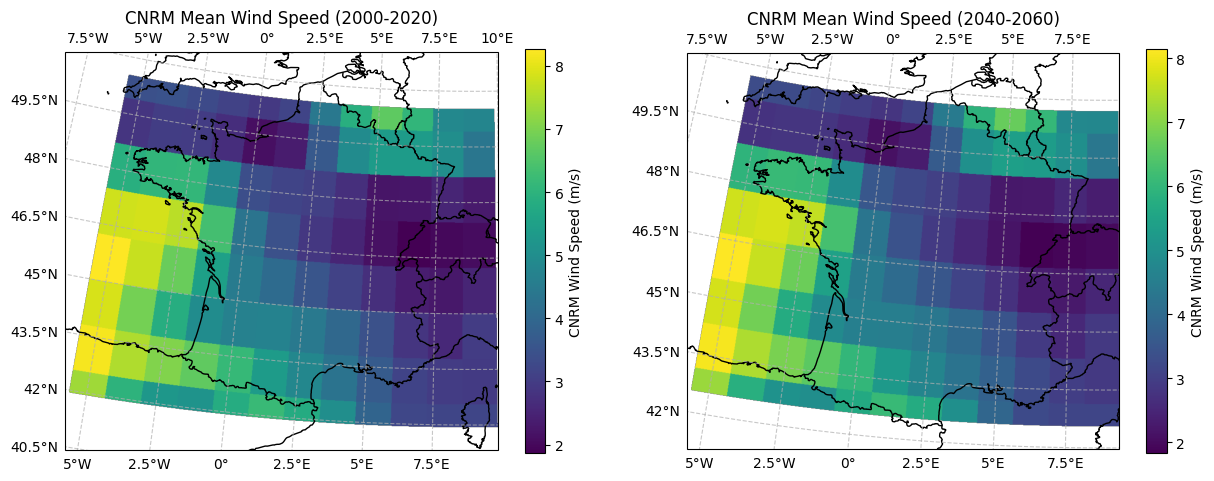

In [166]:
# plot means
plot_maps(cnrm_mean_wind_2000_2020.data, cnrm_mean_wind_2040_2060.data, 
          'viridis', 'viridis', 
          'CNRM Wind Speed (m/s)', 'CNRM Wind Speed (m/s)',
          'CNRM Mean Wind Speed (2000-2020)', 'CNRM Mean Wind Speed (2040-2060)', 
          extent_cnrm, extent_mpi)

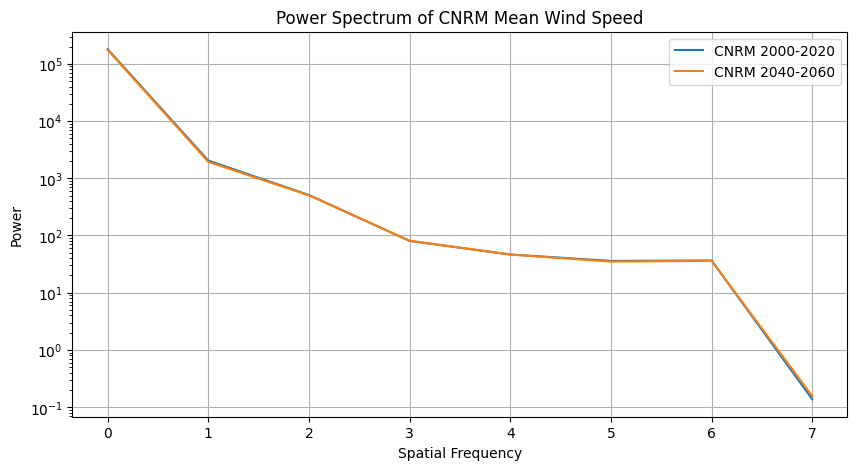

In [167]:
plot_power_spectrum(cnrm_mean_wind_2000_2020.data, cnrm_mean_wind_2040_2060.data,
                    'CNRM 2000-2020', 'CNRM 2040-2060',
                    'Power Spectrum of CNRM Mean Wind Speed')

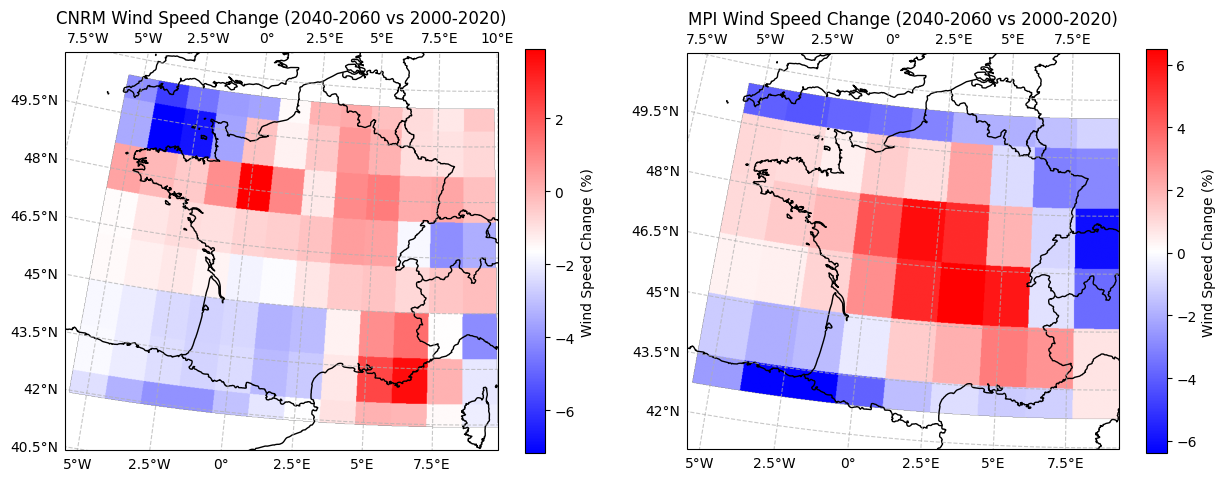

In [169]:
plot_maps(delta_mean_cnrm.data, delta_mean_mpi.data, 
          'bwr', 'bwr', 
          'Wind Speed Change (%)', 'Wind Speed Change (%)',
          'CNRM Wind Speed Change (2040-2060 vs 2000-2020)', 
          'MPI Wind Speed Change (2040-2060 vs 2000-2020)', 
          extent_cnrm, extent_mpi)

## Max GCM

In [170]:
mpi_2000_2020

<xarray.Dataset> Size: 2MB
Dimensions:  (time: 7671, lat: 6, lon: 9)
Coordinates:
  * time     (time) datetime64[ns] 61kB 2000-01-01 2000-01-02 ... 2020-12-31
  * lon      (lon) float64 72B -5.625 -3.75 -1.875 0.0 ... 3.75 5.625 7.5 9.375
  * lat      (lat) float64 48B 41.97 43.83 45.7 47.56 49.43 51.29
Data variables:
    sfcWind  (time, lat, lon) float32 2MB 5.825 4.929 4.481 ... 11.33 8.682
Attributes: (12/49)
    CDI:                    Climate Data Interface version ?? (http://mpimet....
    history:                Thu Jun 06 19:35:49 2024: cdo sellonlatbox,-6.0,1...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    ...                     ...
    variable_id:            sfcWind
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/d9c7d499-6df0-41c4-891b-1dc85963a6ce
    CDO:                    Climate Data Operators version 1.9.3 (http://mpim...

In [171]:
cnrm_max_wind_2000_2020 = cnrm_2000_2020.sfcWind.max(dim="time")
cnrm_max_wind_2040_2060 = cnrm_2040_2060.sfcWind.max(dim="time")
mpi_max_wind_2000_2020 = mpi_2000_2020.sfcWind.max(dim="time")
mpi_max_wind_2040_2060 = mpi_2040_2060.sfcWind.max(dim="time")

In [172]:
delta_max_cnrm = (cnrm_max_wind_2040_2060 - cnrm_max_wind_2000_2020) / cnrm_max_wind_2000_2020 * 100
delta_max_mpi = (mpi_max_wind_2040_2060 - mpi_max_wind_2000_2020) / mpi_max_wind_2000_2020 * 100

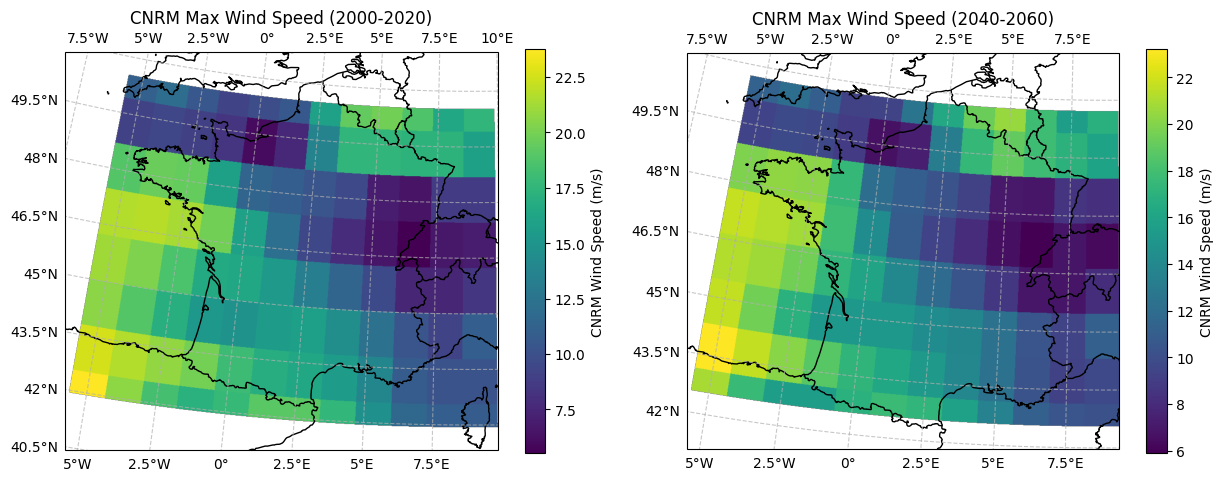

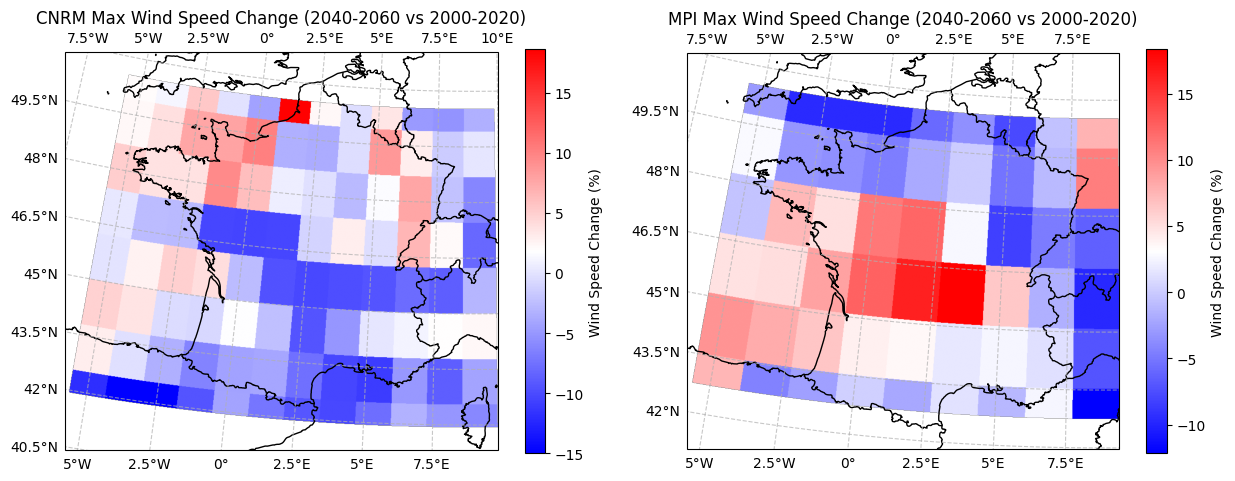

In [173]:
plot_maps(cnrm_max_wind_2000_2020.data, cnrm_max_wind_2040_2060.data, 
          'viridis', 'viridis', 
          'CNRM Wind Speed (m/s)', 'CNRM Wind Speed (m/s)',
          'CNRM Max Wind Speed (2000-2020)', 'CNRM Max Wind Speed (2040-2060)', 
          extent_cnrm, extent_mpi)
# plot deltas max
plot_maps(delta_max_cnrm.data, delta_max_mpi.data, 
          'bwr', 'bwr',
            'Wind Speed Change (%)', 'Wind Speed Change (%)',
            'CNRM Max Wind Speed Change (2040-2060 vs 2000-2020)', 
            'MPI Max Wind Speed Change (2040-2060 vs 2000-2020)',
          extent_cnrm, extent_mpi)

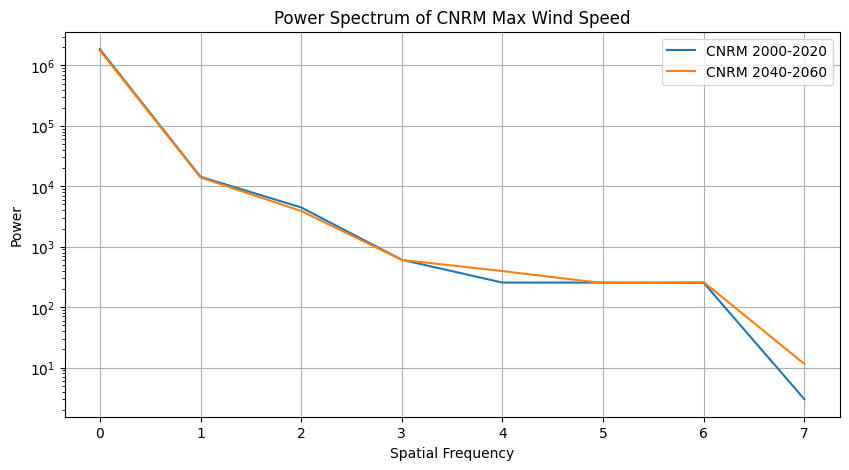

In [174]:
plot_power_spectrum(cnrm_max_wind_2000_2020.data, cnrm_max_wind_2040_2060.data,
                    'CNRM 2000-2020', 'CNRM 2040-2060',
                    'Power Spectrum of CNRM Max Wind Speed')

## 95th quantile

In [175]:
cnrm_95_wind_2000_2020 = cnrm_2000_2020.sfcWind.quantile(0.95, dim="time")
cnrm_95_wind_2040_2060 = cnrm_2040_2060.sfcWind.quantile(0.95, dim="time")
mpi_95_wind_2000_2020 = mpi_2000_2020.sfcWind.quantile(0.95, dim="time")
mpi_95_wind_2040_2060 = mpi_2040_2060.sfcWind.quantile(0.95, dim="time")

In [176]:
delta_95_cnrm = cnrm_95_wind_2040_2060 - cnrm_95_wind_2000_2020
delta_95_mpi = mpi_95_wind_2040_2060 - mpi_95_wind_2000_2020

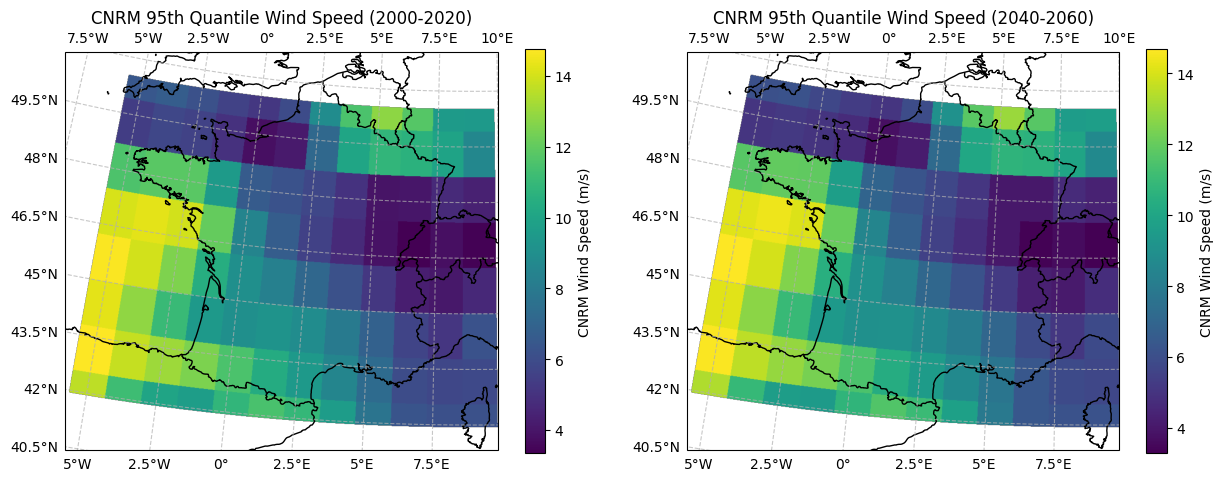

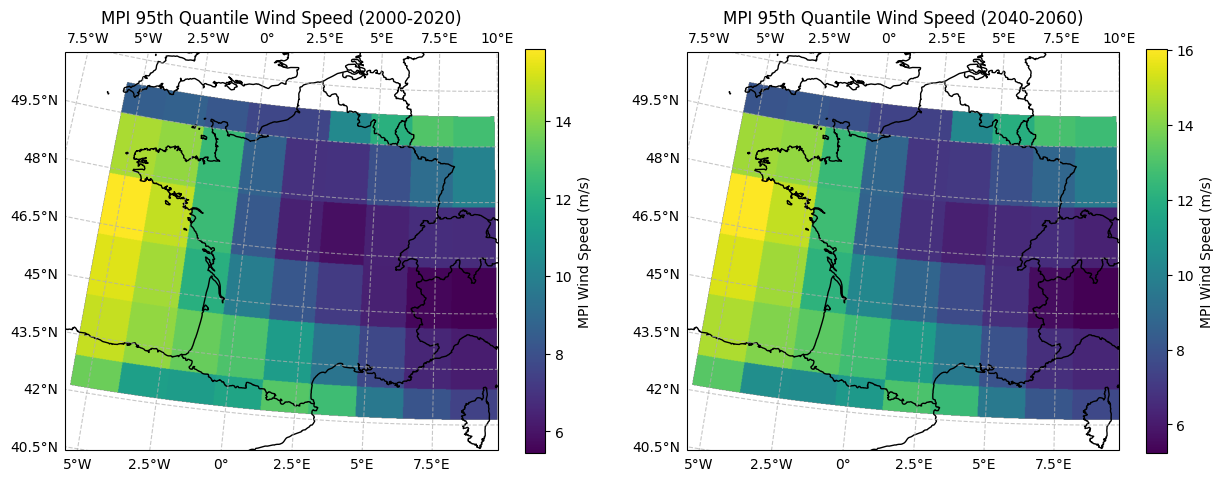

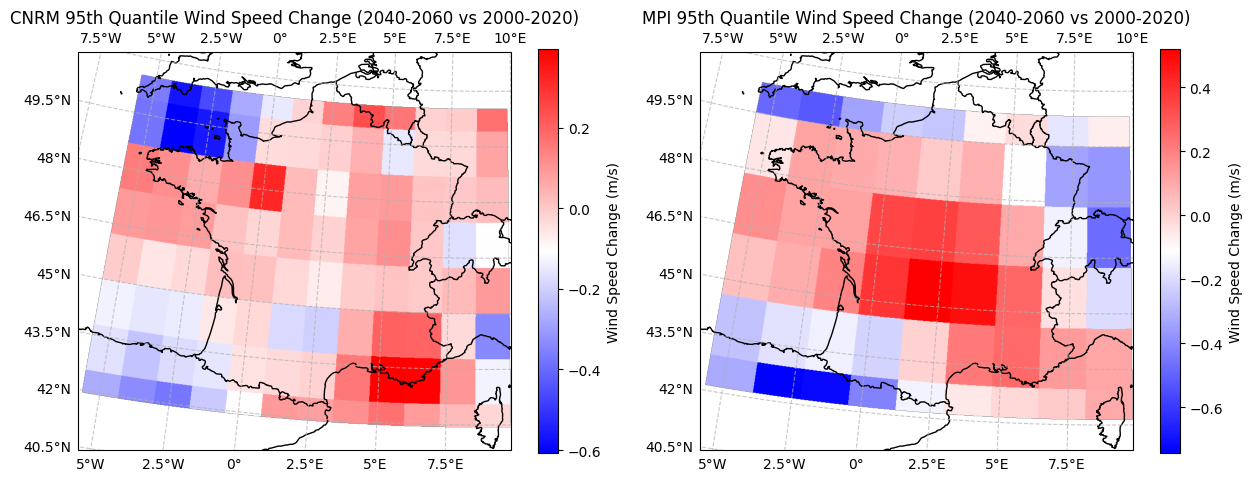

In [177]:
# plot 95th quantile CNRM
plot_maps(cnrm_95_wind_2000_2020.data, cnrm_95_wind_2040_2060.data, 
          'viridis', 'viridis', 
          'CNRM Wind Speed (m/s)', 'CNRM Wind Speed (m/s)',
          'CNRM 95th Quantile Wind Speed (2000-2020)', 'CNRM 95th Quantile Wind Speed (2040-2060)',
            extent_cnrm, extent_cnrm)
# plot 95th quantile MPI
plot_maps(mpi_95_wind_2000_2020.data, mpi_95_wind_2040_2060.data, 
          'viridis', 'viridis', 
          'MPI Wind Speed (m/s)', 'MPI Wind Speed (m/s)',
          'MPI 95th Quantile Wind Speed (2000-2020)', 'MPI 95th Quantile Wind Speed (2040-2060)',
            extent_cnrm, extent_cnrm)
# plot deltas 95th quantile
plot_maps(delta_95_cnrm.data, delta_95_mpi.data, 
          'bwr', 'bwr',
            'Wind Speed Change (m/s)', 'Wind Speed Change (m/s)',
            'CNRM 95th Quantile Wind Speed Change (2040-2060 vs 2000-2020)', 
            'MPI 95th Quantile Wind Speed Change (2040-2060 vs 2000-2020)',
          extent_cnrm, extent_cnrm)

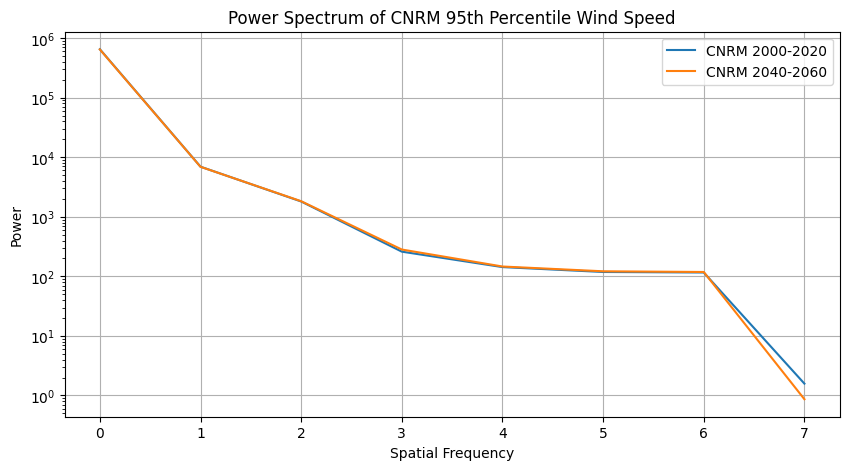

In [178]:
plot_power_spectrum(cnrm_95_wind_2000_2020.data, cnrm_95_wind_2040_2060.data,
                    'CNRM 2000-2020', 'CNRM 2040-2060',
                    'Power Spectrum of CNRM 95th Percentile Wind Speed')

## Moyennes saisonnières

In [179]:
cnrm_djf_mean_2000_2020 = cnrm_2000_2020.sfcWind.sel(time=cnrm_2000_2020.time.dt.season == "DJF").groupby("time.year").mean("time").mean("year")
cnrm_mam_mean_2000_2020 = cnrm_2000_2020.sfcWind.sel(time=cnrm_2000_2020.time.dt.season == "MAM").groupby("time.year").mean("time").mean("year")
cnrm_jja_mean_2000_2020 = cnrm_2000_2020.sfcWind.sel(time=cnrm_2000_2020.time.dt.season == "JJA").groupby("time.year").mean("time").mean("year")
cnrm_son_mean_2000_2020 = cnrm_2000_2020.sfcWind.sel(time=cnrm_2000_2020.time.dt.season == "SON").groupby("time.year").mean("time").mean("year")

cnrm_djf_mean_2040_2060 = cnrm_2040_2060.sfcWind.sel(time=cnrm_2040_2060.time.dt.season == "DJF").groupby("time.year").mean("time").mean("year")
cnrm_mam_mean_2040_2060 = cnrm_2040_2060.sfcWind.sel(time=cnrm_2040_2060.time.dt.season == "MAM").groupby("time.year").mean("time").mean("year")
cnrm_jja_mean_2040_2060 = cnrm_2040_2060.sfcWind.sel(time=cnrm_2040_2060.time.dt.season == "JJA").groupby("time.year").mean("time").mean("year")
cnrm_son_mean_2040_2060 = cnrm_2040_2060.sfcWind.sel(time=cnrm_2040_2060.time.dt.season == "SON").groupby("time.year").mean("time").mean("year")

In [180]:
delta_djf_cnrm = (cnrm_djf_mean_2040_2060 - cnrm_djf_mean_2000_2020) / cnrm_djf_mean_2000_2020 * 100
delta_mam_cnrm = (cnrm_mam_mean_2040_2060 - cnrm_mam_mean_2000_2020) / cnrm_mam_mean_2000_2020 * 100
delta_jja_cnrm = (cnrm_jja_mean_2040_2060 - cnrm_jja_mean_2000_2020) / cnrm_jja_mean_2000_2020 * 100
delta_son_cnrm = (cnrm_son_mean_2040_2060 - cnrm_son_mean_2000_2020) / cnrm_son_mean_2000_2020 * 100

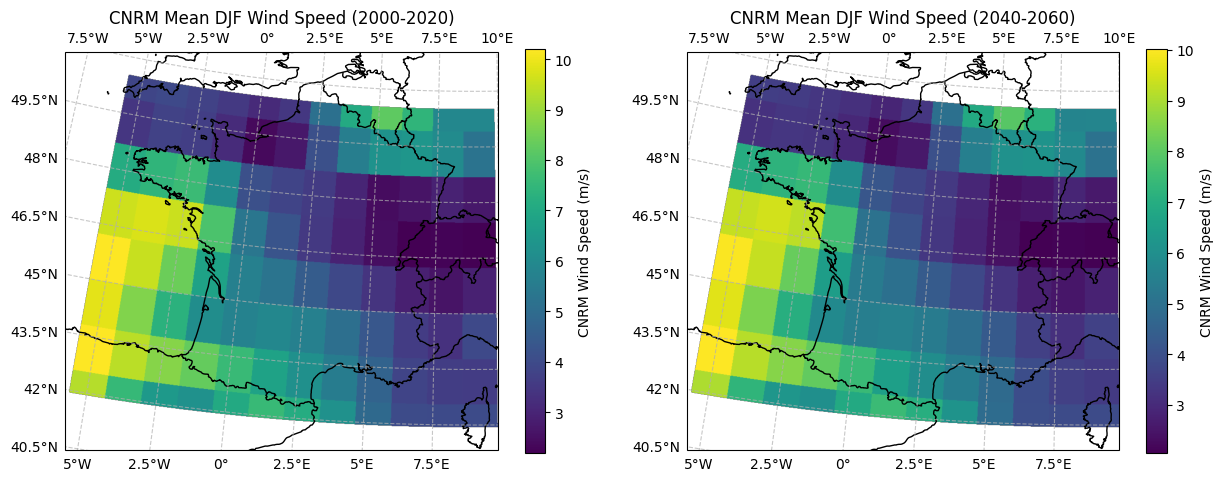

In [181]:
# plot mean djf
plot_maps(cnrm_djf_mean_2000_2020.data, cnrm_djf_mean_2040_2060.data, 
          'viridis', 'viridis', 
          'CNRM Wind Speed (m/s)', 'CNRM Wind Speed (m/s)',
          'CNRM Mean DJF Wind Speed (2000-2020)', 'CNRM Mean DJF Wind Speed (2040-2060)', 
          extent_cnrm, extent_cnrm)
# plot mean mam
# plot_maps(cnrm_mam_mean_2000_2020.data, cnrm_mam_mean_2040_2060.data, 
#           'viridis', 'viridis', 
#           'CNRM Wind Speed (m/s)', 'CNRM Wind Speed (m/s)',
#           'CNRM Mean MAM Wind Speed (2000-2020)', 'CNRM Mean MAM Wind Speed (2040-2060)', 
#           extent_gcm)
# # plot mean jja
# plot_maps(cnrm_jja_mean_2000_2020.data, cnrm_jja_mean_2040_2060.data, 
#           'viridis', 'viridis', 
#           'CNRM Wind Speed (m/s)', 'CNRM Wind Speed (m/s)',
#           'CNRM Mean JJA Wind Speed (2000-2020)', 'CNRM Mean JJA Wind Speed (2040-2060)', 
#           extent_gcm)
# # plot mean son
# plot_maps(cnrm_son_mean_2000_2020.data, cnrm_son_mean_2040_2060.data, 
#           'viridis', 'viridis', 
#           'CNRM Wind Speed (m/s)', 'CNRM Wind Speed (m/s)',
#           'CNRM Mean SON Wind Speed (2000-2020)', 'CNRM Mean SON Wind Speed (2040-2060)', 
#           extent_gcm)

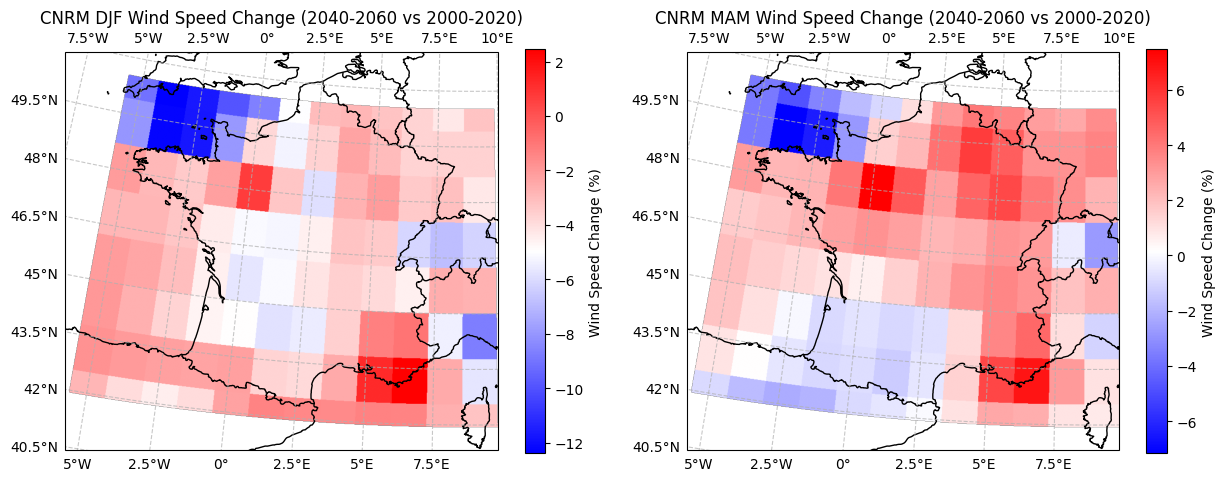

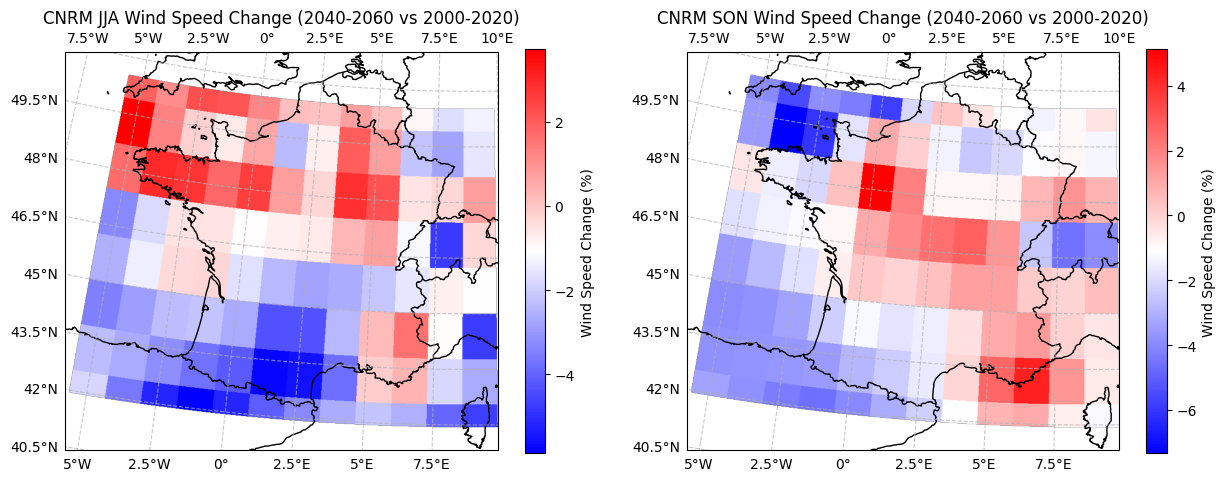

In [182]:
# plot deltas seasonal
plot_maps(delta_djf_cnrm.data, delta_mam_cnrm.data, 
          'bwr', 'bwr',
            'Wind Speed Change (%)', 'Wind Speed Change (%)',
            'CNRM DJF Wind Speed Change (2040-2060 vs 2000-2020)', 
            'CNRM MAM Wind Speed Change (2040-2060 vs 2000-2020)',
          extent_cnrm, extent_cnrm)  
plot_maps(delta_jja_cnrm.data, delta_son_cnrm.data, 
          'bwr', 'bwr',
            'Wind Speed Change (%)', 'Wind Speed Change (%)',
            'CNRM JJA Wind Speed Change (2040-2060 vs 2000-2020)', 
            'CNRM SON Wind Speed Change (2040-2060 vs 2000-2020)',
          extent_cnrm, extent_cnrm)   

## Cycles saisonniers

In [183]:
# plot the means of each day of the year
# group by day of year and take mean over years

daily_means_cnrm_2000_2020 = cnrm_2000_2020.sfcWind.groupby('time.dayofyear').mean('time').mean('lat').mean('lon')
daily_means_cnrm_2040_2060 = cnrm_2040_2060.sfcWind.groupby('time.dayofyear').mean('time').mean('lat').mean('lon')
daily_means_mpi_2000_2020 = mpi_2000_2020.sfcWind.groupby('time.dayofyear').mean('time').mean('lat').mean('lon')
daily_means_mpi_2040_2060 = mpi_2040_2060.sfcWind.groupby('time.dayofyear').mean('time').mean('lat').mean('lon')

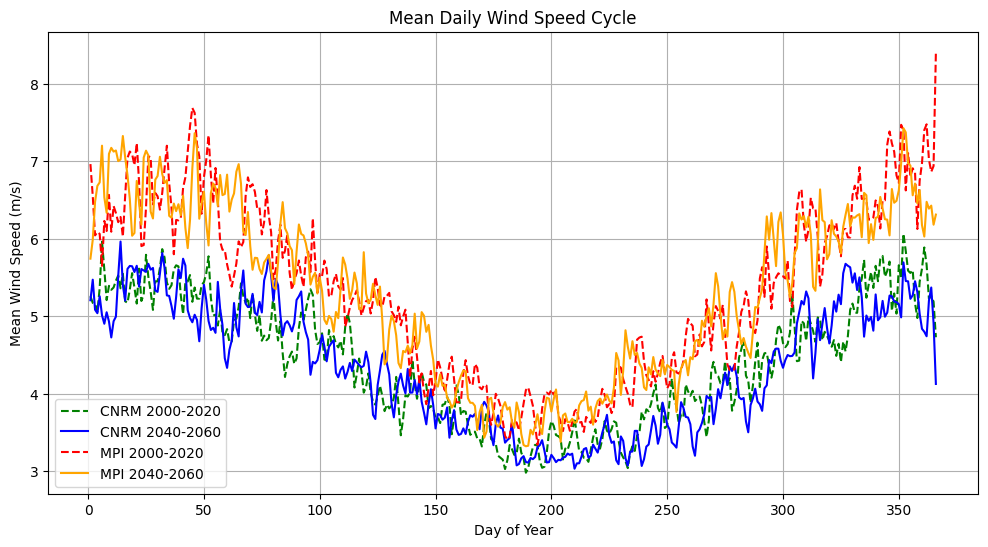

In [184]:
# plot the 4 time series
plt.figure(figsize=(12, 6))
plt.plot(daily_means_cnrm_2000_2020.dayofyear, daily_means_cnrm_2000_2020, label='CNRM 2000-2020', color='green', linestyle='--')
plt.plot(daily_means_cnrm_2040_2060.dayofyear, daily_means_cnrm_2040_2060, label='CNRM 2040-2060', color='blue')
plt.plot(daily_means_mpi_2000_2020.dayofyear, daily_means_mpi_2000_2020, label='MPI 2000-2020', color='red', linestyle='--')
plt.plot(daily_means_mpi_2040_2060.dayofyear, daily_means_mpi_2040_2060, label='MPI 2040-2060', color='orange')
plt.xlabel('Day of Year')
plt.ylabel('Mean Wind Speed (m/s)')
plt.title('Mean Daily Wind Speed Cycle')
plt.legend()
plt.grid()
plt.show()

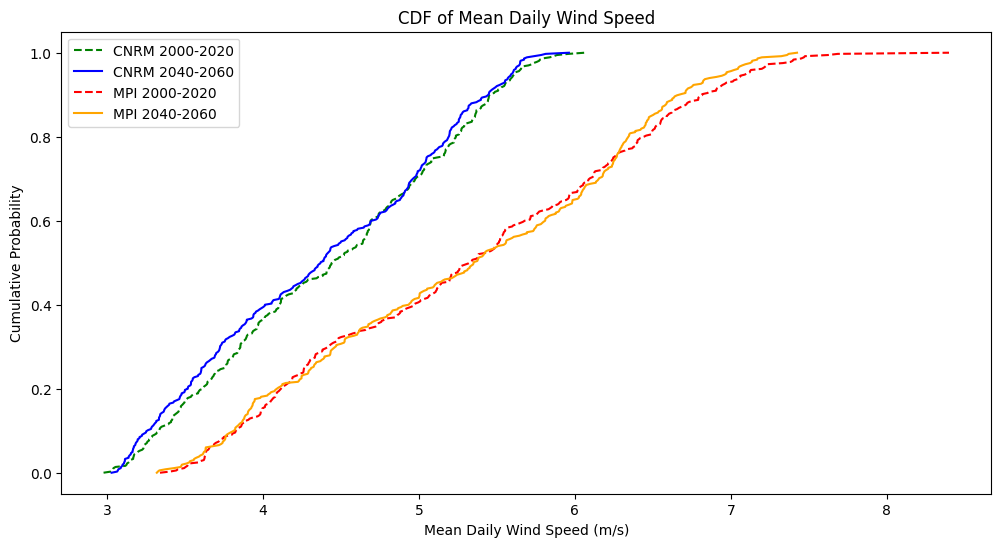

In [185]:
#plot the cdf of daily means for each period and model
plt.figure(figsize=(12, 6))
plt.plot(np.sort(daily_means_cnrm_2000_2020), np.linspace(0, 1, len(daily_means_cnrm_2000_2020)), label='CNRM 2000-2020', color='green', linestyle='--')
plt.plot(np.sort(daily_means_cnrm_2040_2060), np.linspace(0, 1, len(daily_means_cnrm_2040_2060)), label='CNRM 2040-2060', color='blue')
plt.plot(np.sort(daily_means_mpi_2000_2020), np.linspace(0, 1, len(daily_means_mpi_2000_2020)), label='MPI 2000-2020', color='red', linestyle='--')
plt.plot(np.sort(daily_means_mpi_2040_2060), np.linspace(0, 1, len(daily_means_mpi_2040_2060)), label='MPI 2040-2060', color='orange')
plt.xlabel('Mean Daily Wind Speed (m/s)')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Mean Daily Wind Speed')
plt.legend()
plt.show()

## Full CDFs on box

In [204]:
lon_slice = slice(-1.006918, 6.588248)
lat_slice_1 = slice(43.606726, 49.212682)
lat_slice_2 = slice(49.212682, 43.606726)
cropped_cnrm_2000_2020 = cnrm_2000_2020.sel(lon=lon_slice, lat=lat_slice_1)
cropped_cnrm_2040_2060 = cnrm_2040_2060.sel(lon=lon_slice, lat=lat_slice_1)
cropped_mpi_2000_2020 = mpi_2000_2020.sel(lon=lon_slice, lat=lat_slice_1)
cropped_mpi_2040_2060 = mpi_2040_2060.sel(lon=lon_slice, lat=lat_slice_1)
cropped_safran_wind = safran_1989_2025.FF_Q.sel(time=slice("2000-01-01", "2020-12-31")).sel(x=lon_slice, y=lat_slice_2)

In [205]:
flattened_cnrm_2000_2020 = cropped_cnrm_2000_2020.sfcWind.values.flatten()
flattened_cnrm_2040_2060 = cropped_cnrm_2040_2060.sfcWind.values.flatten()
flattened_mpi_2000_2020 = cropped_mpi_2000_2020.sfcWind.values.flatten()
flattened_mpi_2040_2060 = cropped_mpi_2040_2060.sfcWind.values.flatten()
flattened_safran = cropped_safran_wind.values.flatten()

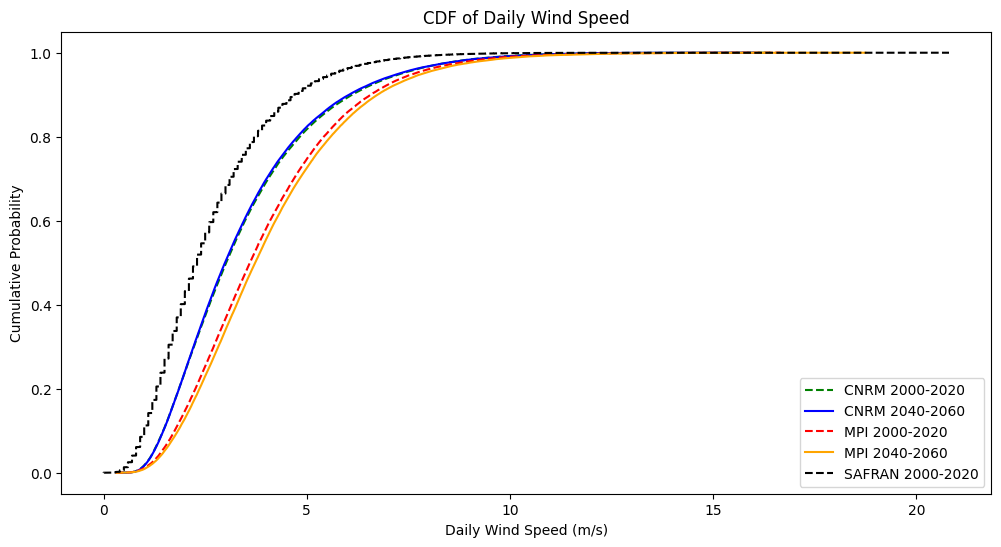

In [208]:
#plot the cdf of daily means for each period and model
plt.figure(figsize=(12, 6))
plt.plot(np.sort(flattened_cnrm_2000_2020), np.linspace(0, 1, len(flattened_cnrm_2000_2020)), label='CNRM 2000-2020', color='green', linestyle='--')
plt.plot(np.sort(flattened_cnrm_2040_2060), np.linspace(0, 1, len(flattened_cnrm_2040_2060)), label='CNRM 2040-2060', color='blue')
plt.plot(np.sort(flattened_mpi_2000_2020), np.linspace(0, 1, len(flattened_mpi_2000_2020)), label='MPI 2000-2020', color='red', linestyle='--')
plt.plot(np.sort(flattened_mpi_2040_2060), np.linspace(0, 1, len(flattened_mpi_2040_2060)), label='MPI 2040-2060', color='orange')
plt.plot(np.sort(flattened_safran), np.linspace(0, 1, len(flattened_safran)), label='SAFRAN 2000-2020', color='black', linestyle='--')
plt.xlabel('Daily Wind Speed (m/s)')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Daily Wind Speed')
plt.legend()
plt.show()